## Assignment 10

### Brief dataset description  

The dataset consists of 569 entries of 30 numeric predictive variables and the outcome.  
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.   

#### Attribute information  
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.  


As found on [sklearn documentation](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset)

In [1]:
# if needed install packages by uncommenting the following line
#!pip install tensorflow

In [2]:
import pandas as pd 
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load the data 
cancerDF = load_breast_cancer(as_frame=True)['frame']

I will be replicating the dataset preparation from assignment 2 in order to compare the results with the results of the best performing random forest.

In [4]:
# split the data into train test  
X = cancerDF[[x for x in cancerDF.columns if x!='target']]
y = cancerDF['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
scaled_df = pd.DataFrame(X_train_scaled)
scaled_df.columns = [col for col in cancerDF.columns if col!='target']
scaled_df['target'] = y_train

def violin_plot(dataset: pd.DataFrame, var_type: str) ->None:
    if var_type not in ['mean', 'error', 'worst']:
        raise ValueError('var_type parameter must be one of "ean", "error" or "worst"')

    data = dataset[[col for col in dataset.columns if var_type in col]+['target']]
    data = pd.melt(data, id_vars="target", var_name="features", value_name='value')
    plt.figure(figsize=(10,5))
    sns.violinplot(x="features", y="value", hue="target", data=data, split=True, inner="quart", palette='GnBu')
    plt.xticks(rotation=45)

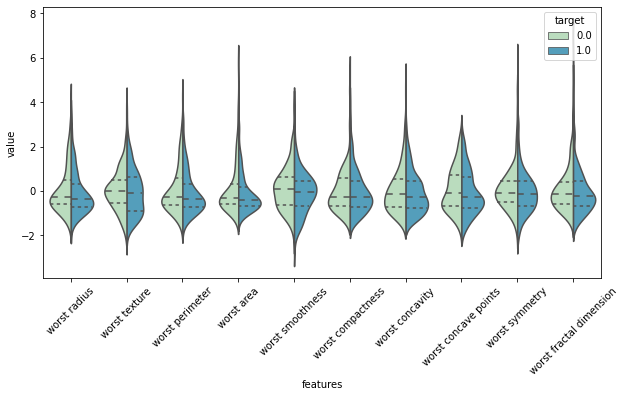

In [7]:
violin_plot(scaled_df, 'worst')

The dataset contains many features and many are correlated with each other.  
A simple and fast filter method to find the best correlated features with the output variable is used.

In [8]:
feat_selector = SelectKBest(k=8)
X_train_selected = feat_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = feat_selector.transform(X_test_scaled)

# also keep the names of the features used 
names=[x for x,y in zip(cancerDF.columns, feat_selector.get_support()) if y]

In [9]:
# best model of assignment 2
rf = RandomForestClassifier(n_estimators=86, criterion='gini', n_jobs=-1)
rf.fit(X_train_selected, y_train)
y_hat = rf.predict(X_test_selected)
accuracy_score(y_test, y_hat)

0.956140350877193

Ensemble modeling in machine learning is practicaly the combination of predictions from multiple models in order to generate a final model which provide better overall performance.  
The motivation behind this technique is to correctly combine weak models to get a more accurate and robust model.  

Depending on how the base models are combined, ensemble learning is typically classified into the following categories:
* Bagging  
Build base models independently and average their results for the final predictions. The base models can be the same but also combining different models is also possible.  
* Boosting  
Boosting models are built sequentially and try to reduce the bias on final predictions.  
* Stacking  
The predictions of each individual model are stacked together and used as input to a final estimator to compute the prediction.

In [10]:
def get_nn_model(n_inp: int) ->keras.Sequential:

    model = Sequential()
    # Adding the input layer and the first hidden layer
    model.add(Dense(units=60, kernel_initializer='uniform', activation='selu', input_dim=n_inp))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=0.2))
    # Adding the second hidden layer
    model.add(Dense(units=12, kernel_initializer='uniform', activation='selu'))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=0.2))
    # Adding the output layer
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    # Compiling the ANN
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

As random forest is a bagging technique, I will make an bagging ensemble of 2-layer neural networks.  
Bagging or bootstrap aggregation method is a statistical technique for estimating quantities about a population by averaging estimates from multiple small data samples. In the bootstrap method the samples are taken by resampling a larger sample (sampling with replacement). In this way an observation can be included in a given small sample more than once. 

In [92]:
n_examples = X_train_selected.shape[0]
scores = []
results_df = pd.DataFrame()

for n in tqdm(range(24)):
    random_sample_rows = np.random.choice(n_examples, size=int(n_examples*0.5), replace=True)
    X_train_sampled = X_train_selected[random_sample_rows, :]
    y_train_sampled = y_train.reset_index(drop=True).iloc[random_sample_rows]
    nn = get_nn_model(X_train_sampled.shape[1])
    nn.fit(X_train_sampled, y_train_sampled, batch_size=120, epochs=120, verbose=0)
    y_pred = [int((value > 0.5)[0]) for value in nn.predict(X_test_selected)]
    results_df[f'nn_{n}'] = y_pred
    scores.append(accuracy_score(y_test, y_pred))


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]


In [93]:
results_df['ensemble_pred'] = results_df.apply(lambda x: int((sum(x)/24) > 0.5), axis=1)
accuracy_score(y_test, results_df['ensemble_pred'])

0.956140350877193

In [125]:
# keep the results in a dataframe

y_pred_rf = rf.predict(X_test_selected)
y_pred_nn_ensemble = results_df['ensemble_pred']

rf_scores_dict = {'Accuracy': accuracy_score(y_test, y_pred_rf),
                  'Recall': recall_score(y_test, y_pred_rf),
                  'Precision': precision_score(y_test, y_pred_rf),
                  'F1': f1_score(y_test, y_pred_rf),
                  }
nn_ens_scores_dict = {'Accuracy': accuracy_score(y_test, y_pred_nn_ensemble),
                      'Recall': recall_score(y_test, y_pred_nn_ensemble),
                      'Precision': precision_score(y_test, y_pred_nn_ensemble),
                      'F1': f1_score(y_test, y_pred_nn_ensemble),
                      }

rf_df = pd.Series(rf_scores_dict).reset_index()
rf_df.columns = ['score', 'result']
rf_df['model'] = 'Random Forest'

nnens_df = pd.Series(rf_scores_dict).reset_index()
nnens_df.columns = ['score', 'result']
nnens_df['model'] = 'NeuralNets Ensemble'

scores_df = rf_df.append(nnens_df)

In [126]:
scores_df

,score,result,model
0,Accuracy,0.964912,Random Forest
1,Recall,0.970149,Random Forest
2,Precision,0.970149,Random Forest
3,F1,0.970149,Random Forest
0,Accuracy,0.964912,NeuralNets Ensemble
1,Recall,0.970149,NeuralNets Ensemble
2,Precision,0.970149,NeuralNets Ensemble
3,F1,0.970149,NeuralNets Ensemble


(0.8, 1.0)

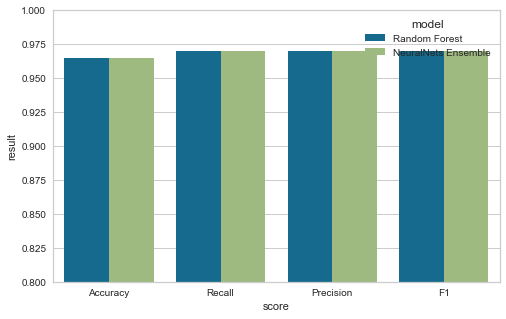

In [128]:
plt.figure(figsize=(8,5))
sns.barplot(x='score', y='result', hue='model', data=scores_df)
plt.ylim(0.8, 1.0)